# Turkish ULMFiT from scratch
Created on: 13 Septembre 2021.

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text.all import *

In [30]:
bs = 144
torch.cuda.set_device(0)
data_path = Config.config_path

lang = "tr"
name = f"{lang}wiki"
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

In [31]:
mdl_path = path/"models"
mdl_path.mkdir(exist_ok=True)
lm_fns = [mdl_path/f"{lang}_wt", mdl_path/f"{lang}_wt_vocab"]

## Turkish wikipedia model

In [32]:
from nlputils import split_wiki, get_wiki

# get_wiki(path, lang)
# !head -n4 {path}/{name}

In [33]:
# dest = split_wiki(path, lang)

In [34]:
get_tr = partial(get_text_files, folders=["docs"])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True, tok=SentencePieceTokenizer("tr")),
    get_items=get_tr, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=bs, seq_len=72, num_workers=os.cpu_count())
dls_lm.show_batch(max_n=2)

,text,text_
0,"▁xxbos ▁xxmaj ▁kütleçekimsel ▁dalgaların ▁ilk ▁gözlemi ▁xxmaj ▁kütleçekimsel ▁dalgaların ▁ilk ▁gözlemi , ▁ilk ▁gözlemi ▁14 ▁xxmaj ▁eylül ▁2015 ▁tarihinde ▁meydana ▁gelmesine ▁rağmen , ▁xxmaj ▁yerçekimsel ▁dalgaların ▁buluşu , ▁daha ▁sonra ▁11 ▁şubat ▁2016 ▁tarihinde , ▁xxup ▁lig o ▁ve ▁xxmaj ▁ vir go ▁iş ▁birliği ▁tarafından , ▁birlikte ▁açıklandı . ▁xxmaj ▁yerçekimi ▁dalgaları ▁ikili ▁yıldız ▁sistemlerinde ▁atar ca ların ▁zamanlama larının ▁üzerindeki ▁etkileri ▁yoluyla , ▁sadece ▁dolaylı ▁olarak ▁anlaşılma kta ya dı","▁xxmaj ▁kütleçekimsel ▁dalgaların ▁ilk ▁gözlemi ▁xxmaj ▁kütleçekimsel ▁dalgaların ▁ilk ▁gözlemi , ▁ilk ▁gözlemi ▁14 ▁xxmaj ▁eylül ▁2015 ▁tarihinde ▁meydana ▁gelmesine ▁rağmen , ▁xxmaj ▁yerçekimsel ▁dalgaların ▁buluşu , ▁daha ▁sonra ▁11 ▁şubat ▁2016 ▁tarihinde , ▁xxup ▁lig o ▁ve ▁xxmaj ▁ vir go ▁iş ▁birliği ▁tarafından , ▁birlikte ▁açıklandı . ▁xxmaj ▁yerçekimi ▁dalgaları ▁ikili ▁yıldız ▁sistemlerinde ▁atar ca ların ▁zamanlama larının ▁üzerindeki ▁etkileri ▁yoluyla , ▁sadece ▁dolaylı ▁olarak ▁anlaşılma kta ya dı ."
1,"▁ii . ▁el - a lam eyn ▁xxmaj ▁muharebesi ' nde ▁( kasım ▁1942 ) ▁xxmaj ▁müttefiklerin ▁zaferi ▁ve ▁özellikle ▁xxmaj ▁stalingrad ▁xxmaj ▁savaşı ' ndaki ▁fe ci ▁yenilgi ▁( ▁şubat ▁1943 ) ▁ - ▁savaştan ▁giderek ▁daha ▁fazla ▁bık an ▁ve ▁kazan ı labileceği nden ▁şüphe lenen ▁xxmaj ▁alman ▁halkına ▁sunmak ▁zor ▁konu lardı . ▁16 ▁xxmaj ▁kasım ▁1942' de ▁xxmaj ▁goebbels , ▁tüm ▁xxmaj ▁ gau le iter ' lar",". ▁el - a lam eyn ▁xxmaj ▁muharebesi ' nde ▁( kasım ▁1942 ) ▁xxmaj ▁müttefiklerin ▁zaferi ▁ve ▁özellikle ▁xxmaj ▁stalingrad ▁xxmaj ▁savaşı ' ndaki ▁fe ci ▁yenilgi ▁( ▁şubat ▁1943 ) ▁ - ▁savaştan ▁giderek ▁daha ▁fazla ▁bık an ▁ve ▁kazan ı labileceği nden ▁şüphe lenen ▁xxmaj ▁alman ▁halkına ▁sunmak ▁zor ▁konu lardı . ▁16 ▁xxmaj ▁kasım ▁1942' de ▁xxmaj ▁goebbels , ▁tüm ▁xxmaj ▁ gau le iter ' lar ▁gibi"


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0001))

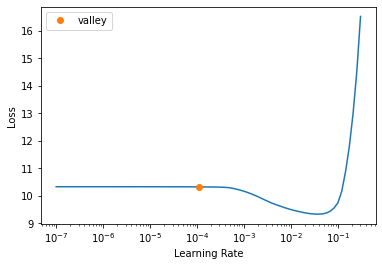

In [35]:
torch.cuda.empty_cache()
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.1, wd=0.1, 
                metrics=[accuracy, Perplexity()], pretrained=False).to_fp16()
learn.lr_find()

In [36]:
lr = 3e-3
lr *= bs/48  # scale lr by batch size

learn.unfreeze()
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.614775,5.773619,0.210335,321.699768,02:44
1,4.755323,5.031287,0.245797,153.129913,02:45
2,4.511978,4.852171,0.258168,128.018066,02:46
3,4.426910,4.771465,0.264296,118.092102,02:47
4,4.361788,4.704693,0.269557,110.464348,02:48
5,4.314601,4.648013,0.271828,104.377342,02:49
6,4.214610,4.575909,0.277089,97.116295,02:50
7,4.152083,4.513559,0.281464,91.245972,02:51
8,4.116148,4.445042,0.285984,85.203430,02:50
9,4.063055,4.342351,0.294970,76.888084,02:51


In [37]:
mdl_path = path/"models"
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(lm_fns[0], with_opt=False)
save_pickle(lm_fns[1].with_suffix(".pkl"), learn.dls.vocab)

## Turkish Sentiment Analysis

In [38]:
path_clas = path/"movies"
path_clas.ls()

(#2) [Path('/home/wabinab/.fastai/trwiki/movies/tr_polarity.pos'),Path('/home/wabinab/.fastai/trwiki/movies/tr_polarity.neg')]

In [39]:
pos = (path_clas/"tr_polarity.pos").open(encoding="iso-8859-9").readlines()
pos_df = pd.DataFrame({"text": pos})
pos_df["pos"] = 1
pos_df.head()

,text,pos
0,gerçekten harika bir yapim birçok kez izledim gene izlerim özgürlük askini ve ingilizlerin ne kadar vahset olduklarini gözler önüne seren bir film ve tabi ki ask.... \n,1
1,her izledigimde hayranlik duydugum gerçek klasik diyebilecegimiz filmlerden . içinde teknik hatalar barindirsa bile sinema olgusunun en üst noktalarindan.. \n,1
2,"gerçekten tarihi savas filmleri arasinda tartismasiz en iyisi , 12 yil boyunca acaba ikincisi çekirimi diye bekledigim bir film ,belki william wallace babasinin ölümünden sonra amcasi yanina almisti onu yetistirmisti belki bunu anlatan mükkemmel bir filim olablilr=). \n",1
3,aldigi ödülleri sonuna dek hak eden muhtesem bir basyapit . \n,1
4,özgürlük denilince aklima gelen ilk film.bir basyapit.. \n,1


In [40]:
neg = (path_clas/"tr_polarity.neg").open(encoding="iso-8859-9").readlines()
neg_df = pd.DataFrame({"text": neg})
neg_df["pos"] = 0
neg_df.head()

,text,pos
0,giseye oynayan bir film.mel gibson'in oyunculugu yine çok kötü.film bastan sona duygu sömürüsü ama anlayan nerde!. \n,0
1,bircok yonden sahip olduklari zayifliklari populerligi iyi kullanmasiyla gidermis zayif bir yapim... \n,0
2,"1995 ten bu yana bu tür filmler artti , o zamanlar basarili sayilabilecekse de suan emin degilim. konusu baya siradan .. \n",0
3,mel gibson tam bir ingiliz düsmani her filminde belirtiyor bunu. film yine cok iyi. biz kurtulus mücadelemizi böyle bir filmle simgeleyemedik. üzülüyorum bu yüzden.. \n,0
4,milliyetçi bir film tavsiye etmiyorum.... \n,0


In [41]:
df = pd.concat([pos_df, neg_df], sort=False)

In [42]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df("text", is_lm=True, vocab=dls_lm.vocab),
    get_items=ColReader("text"), splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, seq_len=72, num_workers=os.cpu_count())
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos ç xxrep 4 o k bos xxunk xxunk cd veya xxunk xxunk xxunk xxunk film xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk . xxbos hem xxunk hem xxunk xxunk bir xxunk xxunk xxunk xxunk çok xxunk xxunk xxunk oldukça xxunk bir xxunk xxunk xxbos xxunk xxunk xxunk xxunk bu xxunk xxunk xxunk da bu xxunk xxunk bir xxunk xxunk xxunk . xxunk bi film xxunk xxunk xxbos film o xxunk,ç xxrep 4 o k bos xxunk xxunk cd veya xxunk xxunk xxunk xxunk film xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk . xxbos hem xxunk hem xxunk xxunk bir xxunk xxunk xxunk xxunk çok xxunk xxunk xxunk oldukça xxunk bir xxunk xxunk xxbos xxunk xxunk xxunk xxunk bu xxunk xxunk xxunk da bu xxunk xxunk bir xxunk xxunk xxunk . xxunk bi film xxunk xxunk xxbos film o xxunk xxunk
1,"xxunk bir film , xxunk bir xxunk xxunk bir xxunk xxunk bir xxunk xxunk . lük xxunk ne xxunk . hiç xxunk 10 xxunk 10 xxunk . xxbos dünya xxunk xxunk a xxunk bir xxunk xxunk bu film de xxunk xxunk . . xxbos çok kötü bir film . xxunk xxunk xxunk xxunk xxunk xxunk xxunk bu xxunk xxunk xxunk xxunk xxunk xxunk . xxbos bir xxunk sever olarak xxunk bir insan","bir film , xxunk bir xxunk xxunk bir xxunk xxunk bir xxunk xxunk . lük xxunk ne xxunk . hiç xxunk 10 xxunk 10 xxunk . xxbos dünya xxunk xxunk a xxunk bir xxunk xxunk bu film de xxunk xxunk . . xxbos çok kötü bir film . xxunk xxunk xxunk xxunk xxunk xxunk xxunk bu xxunk xxunk xxunk xxunk xxunk xxunk . xxbos bir xxunk sever olarak xxunk bir insan olarak"


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0014))

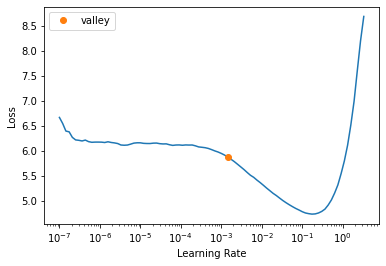

In [43]:
torch.cuda.empty_cache()
learn_lm = language_model_learner(dls_lm, AWD_LSTM, pretrained_fnames=lm_fns, 
            drop_mult=1.0, metrics=accuracy)
learn_lm.lr_find()

In [44]:
lr = 1e-3
lr *= bs/48

learn_lm.fit_one_cycle(1, lr*10)

epoch,train_loss,valid_loss,accuracy,time
0,3.223907,2.359976,0.590404,00:05


In [45]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(lr/10, lr*10))

epoch,train_loss,valid_loss,accuracy,time
0,2.323274,2.284609,0.593409,00:05
1,2.288027,2.127599,0.607427,00:05
2,2.187270,2.088588,0.606209,00:05
3,2.121723,2.068782,0.605875,00:05
4,2.076757,2.062034,0.607323,00:05


In [46]:
learn_lm.save(mdl_path/f"{lang}fine_tuned")
learn_lm.save_encoder(mdl_path/f"{lang}fine_tuned_enc")

## Classifier

In [47]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df("text", vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("pos"), 
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, num_workers=os.cpu_count())
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos o xxunk film xxunk ama bu xxunk xxunk xxunk bir film xxunk xxunk bu xxunk xxunk her xxunk xxunk : xxunk , xxunk , xxunk , xxunk , xxunk , xxunk , xxunk . , . , . , . xxunk xxunk var xxunk tam xxunk m - ü - k - e - m - m - e - l xxunk xxunk daha xxunk xxunk xxunk",1
1,"xxbos xxunk xxunk 2013 xxunk xxunk 2013 xxunk xxunk xxrep 3 ? xxunk xxunk ama xxunk xxunk xxunk 4 - 5 xxunk xxunk xxunk xxunk de xxunk bu xxunk xxunk xxunk bi 3 xxunk xxunk , 4 xxunk daha xxunk . ne ki yani xxunk alt xxunk 4 xxunk xxunk ian xxunk xxunk de , adam 70 xxunk . xxunk xxunk xxunk . . xxunk",1


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0044))

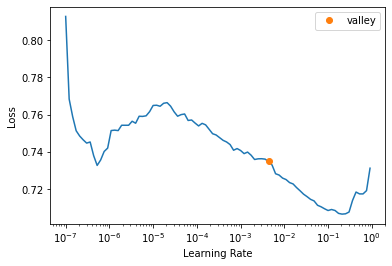

In [48]:
torch.cuda.empty_cache()
learn_c = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
            pretrained=False, metrics=[accuracy, F1Score()], wd=0.1).to_fp16()
learn_c.load_encoder(mdl_path/f"{lang}fine_tuned_enc")
learn_c.freeze()
learn_c.lr_find()

In [49]:
lr = 2e-2
lr *= bs/48

learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.669044,0.652131,0.600375,0.449612,00:03
1,0.633458,0.602144,0.687617,0.679500,00:03


In [50]:
learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.640302,0.619043,0.660413,0.680212,00:03
1,0.626821,0.606859,0.664165,0.683186,00:04


In [51]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.607588,0.575123,0.688555,0.589109,00:03
1,0.559860,0.520369,0.738274,0.722388,00:03


In [52]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4), lr/2))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.561699,0.640088,0.621951,0.392157,00:03
1,0.532977,0.528496,0.727955,0.731481,00:04


In [53]:
learn_c.unfreeze()
learn_c.fit_one_cycle(4, slice(lr/10/(2.6**4), lr/10))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.495248,0.511488,0.741088,0.725646,00:04
1,0.487642,0.528759,0.729831,0.733826,00:04
2,0.469766,0.542421,0.726079,0.726592,00:04
3,0.449999,0.546921,0.726079,0.728119,00:04


In [55]:
learn_c.save(mdl_path/f"{lang}clas")

Path('/home/wabinab/.fastai/trwiki/models/trclas.pth')